In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
file_path = '/content/reviews_dataset.csv'
data = pd.read_csv(file_path)

In [ ]:
data['images'].fillna('no_image', inplace=True)
data['reviewed_at'] = pd.to_datetime(data['reviewed_at'], errors='coerce')
data['crawled_at'] = pd.to_datetime(data['crawled_at'], errors='coerce')
data['description'] = data['description'].str.lower().str.replace('[^\w\s]', '', regex=True)
data.dropna(subset=['name', '_id', 'rating'], inplace=True)

<ipython-input-5-8626c62ddec2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['images'].fillna('no_image', inplace=True)


In [ ]:
analyzer = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['description'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [ ]:
def classify_sentiment(score):
    if score > 0.1:
        return 1
    elif score < -0.1:
        return -1
    else:
        return 0

In [ ]:
data['sentiment_label'] = data['sentiment_score'].apply(classify_sentiment)
data['normalized_sentiment'] = data['sentiment_label'].apply(lambda x: (x + 1) * 2 + 1)

In [ ]:
# Summary of sentiment labels
count_1 = (data['sentiment_label'] == 1).sum()
count_neg1 = (data['sentiment_label'] == -1).sum()
count_0 = (data['sentiment_label'] == 0).sum()
print(f'Positive sentiment count: {count_1}')
print(f'Negative sentiment count: {count_neg1}')
print(f'Neutral sentiment count: {count_0}')

Positive sentiment count: 2703
Negative sentiment count: 140
Neutral sentiment count: 379


In [ ]:
user_item_matrix = data.pivot_table(index='name', columns='_id', values='rating', fill_value=0)
svd = TruncatedSVD(n_components=20, random_state=42)
user_latent_matrix = svd.fit_transform(user_item_matrix)
item_latent_matrix = svd.components_
predicted_ratings = np.dot(user_latent_matrix, item_latent_matrix)
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

In [ ]:
sentiment_matrix = data.pivot_table(index='name', columns='_id', values='normalized_sentiment', fill_value=0)
hybrid_scores = 0.7 * predicted_ratings_df + 0.3 * sentiment_matrix

In [ ]:
descriptions = data['description'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=descriptions, vector_size=50, window=5, min_count=1, workers=4)

In [ ]:
def get_product_vector(description):
    vectors = [w2v_model.wv[word] for word in description.split() if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(50)

In [ ]:
data['product_vector'] = data['description'].apply(get_product_vector)

In [ ]:
def content_based_recommend(user_name, num_recommendations=5):
    user_products = data[data['name'] == user_name]
    positive_products = user_products[user_products['rating'] >= 4]

    if positive_products.empty:
        print(f"No positive ratings for user {user_name}.")
        return []

    user_vector = np.mean([get_product_vector(desc) for desc in positive_products['description']], axis=0)
    data['similarity'] = data['product_vector'].apply(lambda x: np.dot(x, user_vector) / (np.linalg.norm(x) * np.linalg.norm(user_vector)))
    recommended_products = data[~data['_id'].isin(positive_products['_id'])].sort_values(by='similarity', ascending=False).head(num_recommendations)

    return recommended_products['_id'], recommended_products['similarity']

In [ ]:
user_ids = data['name'].astype("category").cat.codes.values
item_ids = data['_id'].astype("category").cat.codes.values
ratings = data['rating'].values
train_data, test_data, train_ratings, test_ratings = train_test_split(
    np.vstack([user_ids, item_ids]).T, ratings, test_size=0.2, random_state=42
)
num_users, num_items = len(set(user_ids)), len(set(item_ids))

In [ ]:
def create_ncf_model(num_users, num_items, embedding_size=50):
    user_input = Input(shape=(1,))
    user_embedding = Embedding(num_users, embedding_size, input_length=1)(user_input)
    user_vector = Flatten()(user_embedding)

    item_input = Input(shape=(1,))
    item_embedding = Embedding(num_items, embedding_size, input_length=1)(item_input)
    item_vector = Flatten()(item_embedding)

    concat = concatenate([user_vector, item_vector])
    dense_1 = Dense(128, activation='relu')(concat)
    dense_2 = Dense(64, activation='relu')(dense_1)
    output = Dense(1, activation='linear')(dense_2)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [ ]:
ncf_model = create_ncf_model(num_users, num_items)
ncf_model.fit([train_data[:, 0], train_data[:, 1]], train_ratings, epochs=5, batch_size=64, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 19.4932
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3833
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3045
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1807
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0889


In [ ]:
def recommend(user_name, num_recommendations=5):
    if user_name not in hybrid_scores.index:
        print(f"User {user_name} not found in the dataset.")
        return []

    user_scores = hybrid_scores.loc[user_name]
    top_products = user_scores.sort_values(ascending=False).head(num_recommendations)
    return top_products.index, top_products.values

In [ ]:
def hybrid_recommend(user_name, num_recommendations=5):
    base_recommendations, base_scores = recommend(user_name, num_recommendations)
    content_recommendations, content_scores = content_based_recommend(user_name, num_recommendations)

    combined_recommendations = {}
    for product, score in zip(base_recommendations, base_scores):
        combined_recommendations[product] = 0.7 * score

    for product, score in zip(content_recommendations, content_scores):
        if product in combined_recommendations:
            combined_recommendations[product] += 0.3 * score
        else:
            combined_recommendations[product] = 0.3 * score

    sorted_recommendations = sorted(combined_recommendations.items(), key=lambda x: x[1], reverse=True)
    return sorted_recommendations[:num_recommendations]

In [ ]:
user_name = 'Zaneera'
recommendations = hybrid_recommend(user_name, num_recommendations=5)

recommendations_df = pd.DataFrame(recommendations, columns=['Product_ID', 'Score'])

print(f"Hybrid Recommendations for user {user_name}:")
print(recommendations_df)

Hybrid Recommendations for user Zaneera:
                             Product_ID     Score
0  cfd992f2-85bc-56a1-9577-1a8bd7ca6c82  2.134735
1  9991435d-f18a-597f-863a-25e547f945f1  0.599938
2  c04ece13-ce9f-5fa3-9c9c-86374f76a56a  0.473173
3  db06b820-5f32-50a2-aab7-7affe2e771ea  0.321913
4  f859da22-f6d3-55ae-9873-ad83aca153d2  0.299970


<ipython-input-15-38d103db25b8>:10: RuntimeWarning: invalid value encountered in scalar divide
  data['similarity'] = data['product_vector'].apply(lambda x: np.dot(x, user_vector) / (np.linalg.norm(x) * np.linalg.norm(user_vector)))


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def rmse(actual_ratings, predicted_ratings):
    return sqrt(mean_squared_error(actual_ratings, predicted_ratings))

def cosine_sim(actual_ratings, predicted_ratings):
    return cosine_similarity([actual_ratings], [predicted_ratings])[0][0]

def get_actual_and_predicted_ratings(user_name):
    if user_name not in user_item_matrix.index:
        print(f"User {user_name} not found in the dataset.")
        return None, None

    actual_ratings = user_item_matrix.loc[user_name].values
    predicted_ratings = predicted_ratings_df.loc[user_name].values
    return actual_ratings, predicted_ratings

user_name = 'Zaneera'
actual_ratings, predicted_ratings = get_actual_and_predicted_ratings(user_name)

if actual_ratings is not None:
    rmse_value = rmse(actual_ratings, predicted_ratings)
    print(f"RMSE for user {user_name}: {rmse_value}")

    cosine_sim_value = cosine_sim(actual_ratings, predicted_ratings)
    print(f"Cosine Similarity for user {user_name}: {cosine_sim_value}")

RMSE for user Zaneera: 0.299798541915112
Cosine Similarity for user Zaneera: 0.6653939979039122


Collaborative Filtering - RMSE for user Zaneera: 0.299798541915112
Collaborative Filtering - Cosine Similarity for user Zaneera: 0.6653939979039122


<ipython-input-23-b70f6ce4b215>:12: RuntimeWarning: invalid value encountered in scalar divide
  data['cbf_similarity'] = data['product_vector'].apply(lambda x: np.dot(x, get_product_vector(' '.join(data[data['name'] == user_name]['description']))) /


Content-Based Filtering - RMSE for user Zaneera: 0.3212877411361201
Content-Based Filtering - Cosine Similarity for user Zaneera: 1.0
Hybrid Model - RMSE for user Zaneera: 0.2098589793405784
Hybrid Model - Cosine Similarity for user Zaneera: 0.8687520525888319


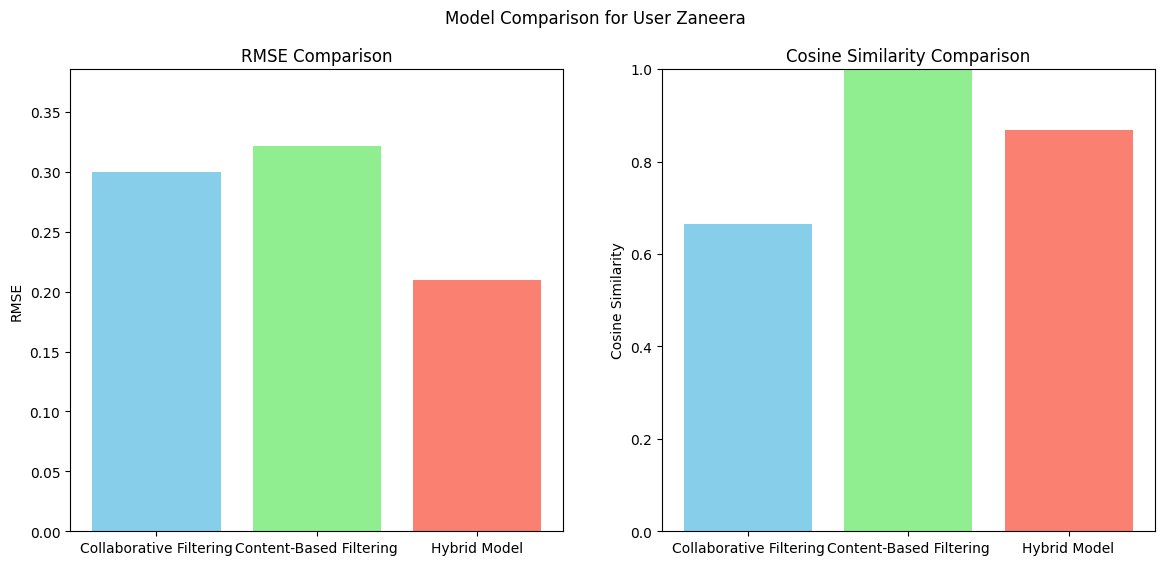

In [ ]:
import matplotlib.pyplot as plt

def compute_metrics(user_name, actual_ratings, model_ratings, model_name):
    rmse_value = rmse(actual_ratings, model_ratings)
    cosine_sim_value = cosine_sim(actual_ratings, model_ratings)
    print(f"{model_name} - RMSE for user {user_name}: {rmse_value}")
    print(f"{model_name} - Cosine Similarity for user {user_name}: {cosine_sim_value}")
    return rmse_value, cosine_sim_value

cf_rmse, cf_cosine_sim = compute_metrics(user_name, actual_ratings, predicted_ratings, "Collaborative Filtering")

data['cbf_similarity'] = data['product_vector'].apply(lambda x: np.dot(x, get_product_vector(' '.join(data[data['name'] == user_name]['description']))) /
                                                     (np.linalg.norm(x) * np.linalg.norm(get_product_vector(' '.join(data[data['name'] == user_name]['description'])))))
cbf_ratings = data.pivot_table(index='name', columns='_id', values='cbf_similarity', fill_value=0)
cbf_rmse, cbf_cosine_sim = compute_metrics(user_name, actual_ratings, cbf_ratings.loc[user_name].values, "Content-Based Filtering")

hybrid_rmse, hybrid_cosine_sim = compute_metrics(user_name, actual_ratings, hybrid_scores.loc[user_name].values, "Hybrid Model")

metrics_dict = {
    'Model': ['Collaborative Filtering', 'Content-Based Filtering', 'Hybrid Model'],
    'RMSE': [cf_rmse, cbf_rmse, hybrid_rmse],
    'Cosine Similarity': [cf_cosine_sim, cbf_cosine_sim, hybrid_cosine_sim]
}

metrics_df = pd.DataFrame(metrics_dict)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(metrics_df['Model'], metrics_df['RMSE'], color=['skyblue', 'lightgreen', 'salmon'])
ax[0].set_title('RMSE Comparison')
ax[0].set_ylabel('RMSE')
ax[0].set_ylim(0, max(metrics_df['RMSE']) * 1.2)

ax[1].bar(metrics_df['Model'], metrics_df['Cosine Similarity'], color=['skyblue', 'lightgreen', 'salmon'])
ax[1].set_title('Cosine Similarity Comparison')
ax[1].set_ylabel('Cosine Similarity')
ax[1].set_ylim(0, 1)

plt.suptitle(f"Model Comparison for User {user_name}")
plt.show()


In [ ]:
user_name = 'Jyoti Mehra'
recommendations = hybrid_recommend(user_name, num_recommendations=5)

recommendations_df = pd.DataFrame(recommendations, columns=['Product_ID', 'Score'])

print(f"Hybrid Recommendations for user {user_name}:")
print(recommendations_df)

Hybrid Recommendations for user Jyoti Mehra:
                             Product_ID     Score
0  772dbeac-0d1c-5030-bfab-5a2080f05654  2.069278
1  77662bb5-11fa-5918-897c-322e4bfd13c9  1.670127
2  60004029-1593-5687-9458-1da9ee849673  0.899965
3  1e94b414-7be2-5933-969b-05760cacddb6  0.567443
4  146b2bfb-a1fc-5981-ab74-5683503f4e0d  0.299992


<ipython-input-15-38d103db25b8>:10: RuntimeWarning: invalid value encountered in scalar divide
  data['similarity'] = data['product_vector'].apply(lambda x: np.dot(x, user_vector) / (np.linalg.norm(x) * np.linalg.norm(user_vector)))


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def rmse(actual_ratings, predicted_ratings):
    return sqrt(mean_squared_error(actual_ratings, predicted_ratings))

def cosine_sim(actual_ratings, predicted_ratings):
    return cosine_similarity([actual_ratings], [predicted_ratings])[0][0]

def get_actual_and_predicted_ratings(user_name):
    if user_name not in user_item_matrix.index:
        print(f"User {user_name} not found in the dataset.")
        return None, None

    actual_ratings = user_item_matrix.loc[user_name].values
    predicted_ratings = predicted_ratings_df.loc[user_name].values
    return actual_ratings, predicted_ratings

user_name = 'Jyoti Mehra'
actual_ratings, predicted_ratings = get_actual_and_predicted_ratings(user_name)

if actual_ratings is not None:
    rmse_value = rmse(actual_ratings, predicted_ratings)
    print(f"RMSE for user {user_name}: {rmse_value}")

    cosine_sim_value = cosine_sim(actual_ratings, predicted_ratings)
    print(f"Cosine Similarity for user {user_name}: {cosine_sim_value}")

RMSE for user Jyoti Mehra: 0.40589964484672725
Cosine Similarity for user Jyoti Mehra: 0.6141233914816446


Collaborative Filtering - RMSE for user Jyoti Mehra: 0.40589964484672725
Collaborative Filtering - Cosine Similarity for user Jyoti Mehra: 0.6141233914816446


<ipython-input-26-b70f6ce4b215>:12: RuntimeWarning: invalid value encountered in scalar divide
  data['cbf_similarity'] = data['product_vector'].apply(lambda x: np.dot(x, get_product_vector(' '.join(data[data['name'] == user_name]['description']))) /


Content-Based Filtering - RMSE for user Jyoti Mehra: 0.4016124536838711
Content-Based Filtering - Cosine Similarity for user Jyoti Mehra: 0.9938834055495875
Hybrid Model - RMSE for user Jyoti Mehra: 0.27184724127627125
Hybrid Model - Cosine Similarity for user Jyoti Mehra: 0.8691518937602492


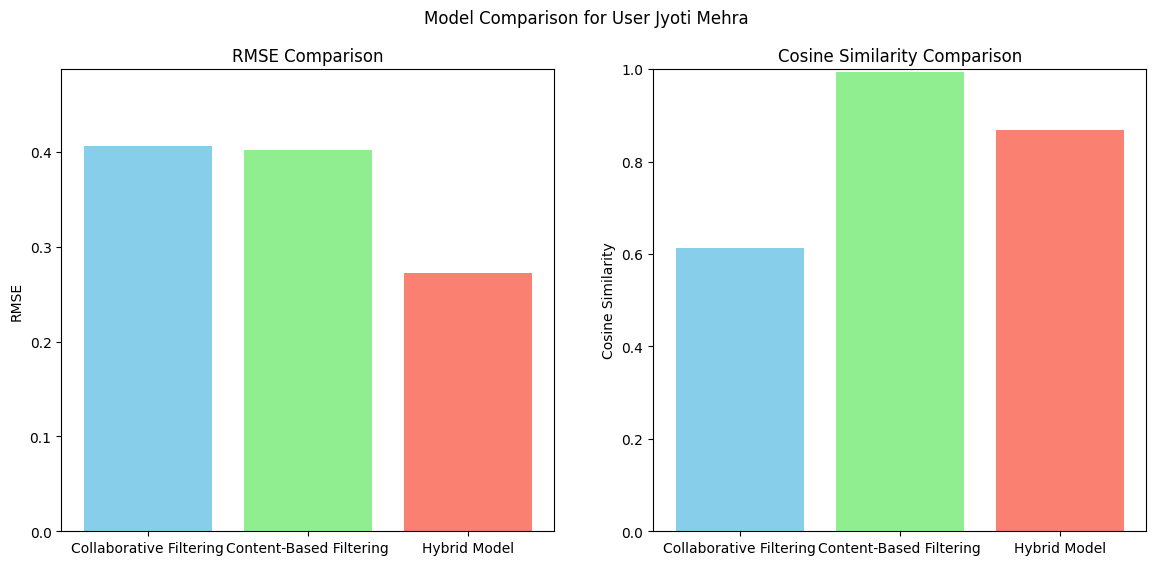

In [ ]:
import matplotlib.pyplot as plt

def compute_metrics(user_name, actual_ratings, model_ratings, model_name):
    rmse_value = rmse(actual_ratings, model_ratings)
    cosine_sim_value = cosine_sim(actual_ratings, model_ratings)
    print(f"{model_name} - RMSE for user {user_name}: {rmse_value}")
    print(f"{model_name} - Cosine Similarity for user {user_name}: {cosine_sim_value}")
    return rmse_value, cosine_sim_value

cf_rmse, cf_cosine_sim = compute_metrics(user_name, actual_ratings, predicted_ratings, "Collaborative Filtering")

data['cbf_similarity'] = data['product_vector'].apply(lambda x: np.dot(x, get_product_vector(' '.join(data[data['name'] == user_name]['description']))) /
                                                     (np.linalg.norm(x) * np.linalg.norm(get_product_vector(' '.join(data[data['name'] == user_name]['description'])))))
cbf_ratings = data.pivot_table(index='name', columns='_id', values='cbf_similarity', fill_value=0)
cbf_rmse, cbf_cosine_sim = compute_metrics(user_name, actual_ratings, cbf_ratings.loc[user_name].values, "Content-Based Filtering")

hybrid_rmse, hybrid_cosine_sim = compute_metrics(user_name, actual_ratings, hybrid_scores.loc[user_name].values, "Hybrid Model")

metrics_dict = {
    'Model': ['Collaborative Filtering', 'Content-Based Filtering', 'Hybrid Model'],
    'RMSE': [cf_rmse, cbf_rmse, hybrid_rmse],
    'Cosine Similarity': [cf_cosine_sim, cbf_cosine_sim, hybrid_cosine_sim]
}

metrics_df = pd.DataFrame(metrics_dict)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(metrics_df['Model'], metrics_df['RMSE'], color=['skyblue', 'lightgreen', 'salmon'])
ax[0].set_title('RMSE Comparison')
ax[0].set_ylabel('RMSE')
ax[0].set_ylim(0, max(metrics_df['RMSE']) * 1.2)

ax[1].bar(metrics_df['Model'], metrics_df['Cosine Similarity'], color=['skyblue', 'lightgreen', 'salmon'])
ax[1].set_title('Cosine Similarity Comparison')
ax[1].set_ylabel('Cosine Similarity')
ax[1].set_ylim(0, 1)

plt.suptitle(f"Model Comparison for User {user_name}")
plt.show()
